# Lista de exercísios #1

**Dataset:** `Kstarmumu_Combined_10K.csv` (binary `label`: 1 = signal, 0 = background)  
**Context:** Binary classification for $ B \to K^{*}\mu^+\mu^- $ (signal vs. background)  
**Libraries:** NumPy, pandas, scikit-learn, matplotlib

In [2]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 42

# Load data

In [3]:
CSV_PATH = "/shared_dataset/Met_Stat_HEP_AI_School/Kstarmumu_Combined_10K.csv"
assert os.path.exists(CSV_PATH), f"CSV not found at {CSV_PATH}"
# Read csv
df = pd.read_csv(CSV_PATH)
print(df.shape, "rows x columns")
# Print example with information of columns
df.head()

(20001, 18) rows x columns


,B0_M,B0_P,B0_PT,B0_DIRA_OWNPV,B0_ENDVERTEX_CHI2,B0_TAU,K_PIDK,Pi_PIDK,mu_plus_PIDmu,mu_minus_PIDmu,B0_FDCHI2_OWNPV,B0_IPCHI2_OWNPV,K_IPCHI2_OWNPV,Pi_IPCHI2_OWNPV,mu_plus_IPCHI2_OWNPV,mu_minus_IPCHI2_OWNPV,q2,label
0,5293.991001,75896.203841,8909.803377,0.999999,4.905650,0.001284,90.508797,-46.337502,12.187781,7.432416,3081.747660,0.371431,59.050087,83.338387,1780.312976,28.701731,9.663302,1
1,5288.832014,126115.585086,10691.039729,1.000000,2.004244,0.001243,24.425800,-30.905701,2.919568,6.710679,2156.295071,0.518954,117.929828,16.125493,148.942208,193.719177,9.641775,1
2,5295.424405,114864.557485,2406.324645,0.999998,12.073755,0.002071,28.216801,-18.581900,6.832418,9.504477,2660.020136,2.568881,27.325995,15.858291,1612.783038,468.393934,9.759748,1
3,5269.043465,54960.554640,2282.680501,0.999985,1.617552,0.001040,27.841700,-56.836899,4.109861,8.587584,607.622240,1.330499,80.198100,98.543575,290.049372,65.434165,9.535254,1
4,5283.438848,152677.844241,7923.259410,1.000000,4.073691,0.004821,6.273400,-31.115299,6.782620,10.778706,30945.021839,5.415031,641.926005,318.035248,1603.637163,10081.557016,9.629298,1


# Descrição das variáveis disponiveis na amostra

In [13]:
assert 'label' in df.columns, "CSV must contain 'label'."
print("Class balance (0=background, 1=signal):")
print(df['label'].value_counts(normalize=True).sort_index())
num_cols = [c for c in df.columns if c != 'label' and np.issubdtype(df[c].dtype, np.number)]
print("Numeric features:", len(num_cols))
# Print columns
print(num_cols)
print("")
# Forma mais simples:
print(df.columns.tolist())

Class balance (0=background, 1=signal):
label
0    0.499975
1    0.500025
Name: proportion, dtype: float64
Numeric features: 17
['B0_M', 'B0_P', 'B0_PT', 'B0_DIRA_OWNPV', 'B0_ENDVERTEX_CHI2', 'B0_TAU', 'K_PIDK', 'Pi_PIDK', 'mu_plus_PIDmu', 'mu_minus_PIDmu', 'B0_FDCHI2_OWNPV', 'B0_IPCHI2_OWNPV', 'K_IPCHI2_OWNPV', 'Pi_IPCHI2_OWNPV', 'mu_plus_IPCHI2_OWNPV', 'mu_minus_IPCHI2_OWNPV', 'q2']

['B0_M', 'B0_P', 'B0_PT', 'B0_DIRA_OWNPV', 'B0_ENDVERTEX_CHI2', 'B0_TAU', 'K_PIDK', 'Pi_PIDK', 'mu_plus_PIDmu', 'mu_minus_PIDmu', 'B0_FDCHI2_OWNPV', 'B0_IPCHI2_OWNPV', 'K_IPCHI2_OWNPV', 'Pi_IPCHI2_OWNPV', 'mu_plus_IPCHI2_OWNPV', 'mu_minus_IPCHI2_OWNPV', 'q2', 'label']


## 1) Explorando os dados
(a) Escolher combinações de 2 variáveis e comparar suas dustribuições em histogramas de 2D.  
(b) Qual separação observada?

In [14]:
# Definindo duas funçoes 
def scatter_2d(df, x, y, label_col='label', max_points=20000):
    m_bg = df[label_col] == 0
    m_sg = df[label_col] == 1

    df_bg, df_sg = df[m_bg], df[m_sg]

    # Plotar usando matplotlib
    fig, ax = plt.subplots()
    ax.scatter(df_bg[x], df_bg[y], s=8, marker='o', label='background')
    ax.scatter(df_sg[x], df_sg[y], s=8, marker='x', label='signal')
    ax.set_xlabel(x); ax.set_ylabel(y); ax.set_title(f"Scatter 2D: {x} vs {y}")
    ax.legend(); plt.show()

def hist_compare(df, col, label_col='label', bins=50, density=True):
    m_bg = df[label_col] == 0; m_sg = df[label_col] == 1
    fig, ax = plt.subplots()
    ax.hist(df.loc[m_bg, col].dropna().values, bins=bins, density=density, alpha=0.5, label='background')
    ax.hist(df.loc[m_sg, col].dropna().values, bins=bins, density=density, alpha=0.5, label='signal')
    ax.set_xlabel(col); ax.set_ylabel("density" if density else "count"); ax.set_title(f"Histogram: {col}")
    ax.legend(); plt.show()


Using for scatter: B0_ENDVERTEX_CHI2 B0_IPCHI2_OWNPV


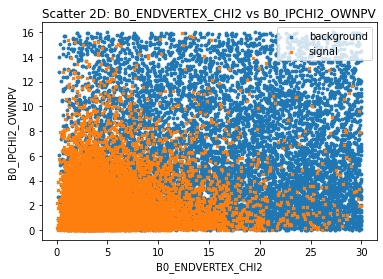

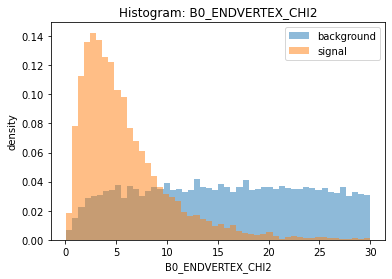

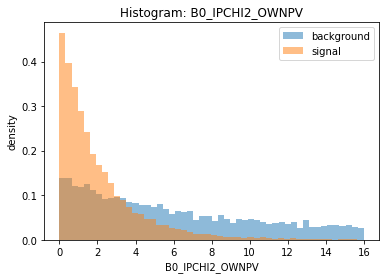

In [15]:
# Escolhendo os plots 2D e 1D
assert len(num_cols) >= 2, "Need at least two numeric features."
X1, X2 = num_cols[4], num_cols[11]
print("Using for scatter:", X1, X2)
scatter_2d(df, X1, X2)
hist_compare(df, X1)
hist_compare(df, X2)


## 2) Definindo uma selecao simples de corte
(a) Defina uma regra simples usando uma variável escolhida (por exemplo: classifique como sinal se y < ythreshold).

(b) Classifique cada evento de acordo com essa regra.

(c) Calcule a eficiência de sinal (True Positive Rate) e a rejeição de background (True Negative Rate).

In [7]:
# E.g. Escolhi B0_ENDVERTEX_CHI2 como referencia
Y_VAR = num_cols[4]

# Seleciona todos os masks (sig ou bkg)
y_true = df['label'].values

# Escolha um valor para cortar
y_threshold = 14
print(f"Threshold variable: {Y_VAR} | y_threshold={y_threshold:.6g}")
# Convertendo para boolean 1,0 para facilitar comparacao com y_true depois
pred_rule = (df[Y_VAR].values < y_threshold).astype(int)

# Definir as regras para calcular eff/rejection
# Sinal que passou a selecao 
tp = np.sum((y_true == 1) & (pred_rule == 1))
# Sinal cortado
fn = np.sum((y_true == 1) & (pred_rule == 0))
# Background que foi rejeitado
tn = np.sum((y_true == 0) & (pred_rule == 0))
# Background que passou a selecao
fp = np.sum((y_true == 0) & (pred_rule == 1))

# Calculando efficiencia do sinal rejeicao do background
tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan
tnr = tn / (tn + fp) if (tn + fp) > 0 else np.nan
print(f"Signal efficiency: {tpr:.4f}")
print(f"Background rejection: {tnr:.4f}")

Threshold variable: B0_ENDVERTEX_CHI2 | y_threshold=14
Signal efficiency: 0.9403
Background rejection: 0.5605



## 3) Decisao linear

(a) Construa um modelo linear  como uma aproximação da forma y = m*x + b

(b) Classifique cada evento usando esse modelo

(c) Avalie o desempenho calculando a eficiência de sinal e a rejeição de background

(d) Compare os resultados com aqueles obtidos pela regra de corte simples

Signal efficiency: 0.9427
Background rejection: 0.6519


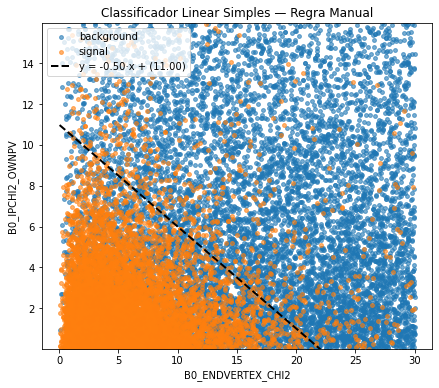

In [8]:
# Escolher valores para m e b
m = -0.5  
b = 11

# Neste caso vou usar B0_ENDVERTEX_CHI2 e B0_IPCHI2_OWNPV
x = df['B0_ENDVERTEX_CHI2'].values
y = df['B0_IPCHI2_OWNPV'].values
y_true = df['label'].values 

# Classificação: sinal se estiver abaixo da reta (y <= kx + l)
pred_rule = (y <= (m * x + b)).astype(int)

# Sinal que passou a selecao 
tp = np.sum((y_true == 1) & (pred_rule == 1))
# Sinal cortado
fn = np.sum((y_true == 1) & (pred_rule == 0))
# Background que foi rejeitado
tn = np.sum((y_true == 0) & (pred_rule == 0))
# Background que passou a selecao
fp = np.sum((y_true == 0) & (pred_rule == 1))


# Eficiência de sinal e rejeição de background
tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

print(f"Signal efficiency: {tpr:.4f}")
print(f"Background rejection: {tnr:.4f}")

# Vamos plotar!
xx = np.linspace(x.min(), x.max(), 200)
yy = m * xx + b

plt.figure(figsize=(7,6))
plt.scatter(x[y_true == 0], y[y_true == 0], s=15, label='background', alpha=0.6)
plt.scatter(x[y_true == 1], y[y_true == 1], s=15, label='signal', alpha=0.6)
plt.plot(xx, yy, 'k--', lw=2, label=f'y = {m:.2f}·x + ({b:.2f})')
plt.xlabel('B0_ENDVERTEX_CHI2')
plt.ylabel('B0_IPCHI2_OWNPV')
plt.title('Classificador Linear Simples — Regra Manual')
plt.legend()
plt.ylim(y.min(), y.max())
plt.show()




## 4) Medindo a Performance
(a) Implementar a AUC.  

(b) Plotar a ROC para os dois exemplos

(c) Comparar as AUCs.


In [9]:
def compute_roc_simple(y_true, scores, n_steps=50):
    """
    Calcula a curva ROC testando vários thresholds.
    """
    thresholds = np.linspace(scores.min(), scores.max(), n_steps)
    tpr_list, fpr_list = [], []

    for t in thresholds:
        y_pred = (scores >= t).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return np.array(fpr_list), np.array(tpr_list), thresholds

def compute_auc_simple(fpr, tpr):
    """
    Calcula a área sob a curva (AUC) via integração trapezoidal
    """
    idx = np.argsort(fpr)        
    return np.trapz(tpr[idx], fpr[idx])

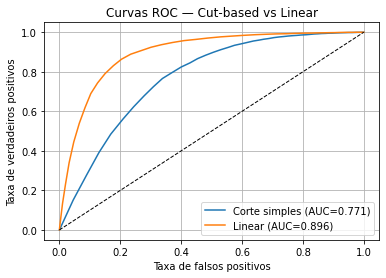

In [10]:
x = df['B0_ENDVERTEX_CHI2'].values
y = df['B0_IPCHI2_OWNPV'].values
y_true = df['label'].values

m, b = -0.5, 11

# Scores usados nas curvas ROC
score_cut = -y                       
score_linear = (m * x + b) - y 


# Calculando os ROC
fpr_cut, tpr_cut, thr_cut = compute_roc_simple(y_true, score_cut)
fpr_lin, tpr_lin, thr_lin = compute_roc_simple(y_true, score_linear)

auc_cut = compute_auc_simple(fpr_cut, tpr_cut)
auc_lin = compute_auc_simple(fpr_lin, tpr_lin)

plt.plot(fpr_cut, tpr_cut, label=f"Corte simples (AUC={auc_cut:.3f})")
plt.plot(fpr_lin, tpr_lin, label=f"Linear (AUC={auc_lin:.3f})")
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("Taxa de falsos positivos")
plt.ylabel("Taxa de verdadeiros positivos")
plt.title("Curvas ROC — Cut-based vs Linear")
plt.legend()
plt.grid(True)
plt.show()

## 5) Regularização e Overfitting (real variables)

a) Gere modelos de regressão polinomial de ordem crescente e avalie o erro de treino e o erro de teste em função da complexidade do modelo.  

b) Aplique regularização do tipo L1 (Lasso) e L2 (Ridge)

c) Avalia o bias–variance trade-off

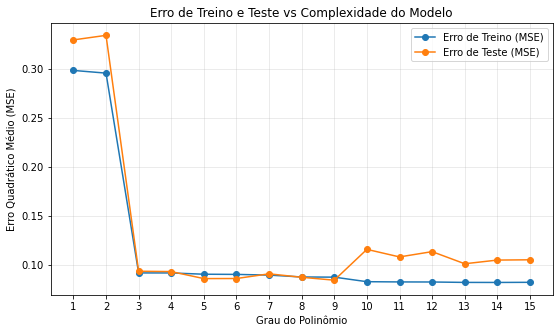

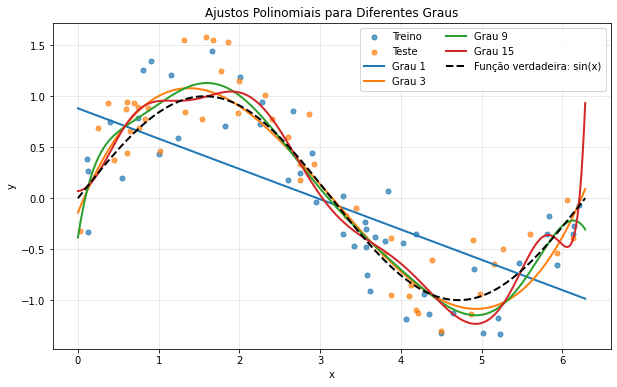

In [11]:
np.random.seed(0)                         
n_samples = 100                           
X = np.sort(np.random.rand(n_samples) * 2 * np.pi)  
y = np.sin(X) + 0.3 * np.random.randn(n_samples)

# sklearn espera X com shape (n_amostras, n_features)
X = X[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

degrees = range(1, 16)   # 
train_errors = []
test_errors  = []

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)

    # Predições em treino e teste
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # Erro quadrático médio (MSE)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse  = mean_squared_error(y_test, y_test_pred)

    train_errors.append(train_mse)
    test_errors.append(test_mse)

plt.figure(figsize=(9, 5))
plt.plot(degrees, train_errors, marker='o', label='Erro de Treino (MSE)')
plt.plot(degrees, test_errors,  marker='o', label='Erro de Teste (MSE)')
plt.xlabel('Grau do Polinômio')
plt.ylabel('Erro Quadrático Médio (MSE)')
plt.title('Erro de Treino e Teste vs Complexidade do Modelo')
plt.xticks(degrees)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# --------------------------------------------
graus_para_ver = [1, 3, 9, 15]  
x_plot = np.linspace(0, 2*np.pi, 400).reshape(-1, 1)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, s=25, alpha=0.7, label='Treino')
plt.scatter(X_test,  y_test,  s=25, alpha=0.7, label='Teste')

for d in graus_para_ver:
    model = make_pipeline(PolynomialFeatures(d), LinearRegression())
    model.fit(X_train, y_train)
    y_plot = model.predict(x_plot)
    plt.plot(x_plot, y_plot, lw=2, label=f'Grau {d}')

plt.plot(x_plot, np.sin(x_plot), 'k--', lw=2, label='Função verdadeira: sin(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Ajustos Polinomiais para Diferentes Graus')
plt.legend(ncol=2)
plt.grid(True, alpha=0.3)
plt.show()

/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.70827e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.357e+00, tolerance: 6.503e-03
  model = cd_fast.enet_coordinate_descent(


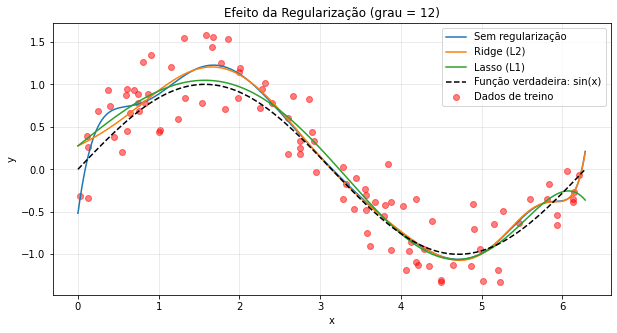

In [12]:
# Escolher um grau alto para mostrar overfitting
degree = 12  

# Definir modelos com diferentes tipos de regularização
models = {
    "Sem regularização": LinearRegression(),
    "Ridge (L2)": Ridge(alpha=1.0),
    "Lasso (L1)": Lasso(alpha=0.01, max_iter=10000)
}

# 4) Preparar grid para visualizar curvas ajustadas
X_plot = np.linspace(0, 2 * np.pi, 500).reshape(-1, 1)
true_y = np.sin(X_plot) 

plt.figure(figsize=(10, 5))

# Treinar e plotar resultados de cada modelo
for name, model in models.items():
    pipeline = make_pipeline(PolynomialFeatures(degree), model)
    pipeline.fit(X, y)
    y_pred = pipeline.predict(X_plot)
    plt.plot(X_plot, y_pred, label=name)

# Plotar função verdadeira e dados de treino
plt.plot(X_plot, true_y, color='black', linestyle='--', label='Função verdadeira: sin(x)')
plt.scatter(X, y, label='Dados de treino', color='red', alpha=0.5)

plt.title(f'Efeito da Regularização (grau = {degree})')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

LinearRegression (sem regularização) → modelo tenta seguir todos os pontos, ajustando até o ruído → overfitting.

Ridge (L2) → penaliza coeficientes grandes, suaviza oscilações → curva mais estável.

Lasso (L1) → zera alguns coeficientes, o modelo fica ainda mais simples (com menos termos).

α (alpha) → controla a força da regularização: quanto maior, mais suave a curva.